# fNIRS Hyperscanning cohort preparation for analysis

Author: Patrice Fortin

Date: 2025-01-06

The following Jupyter Notebook shows how to go from raw fNIRS hyperscanning recordings to produce an output file suitable for statistical analysis of Inter-Brain Synchrony (IBS).

The output file can be of `.csv` or `.feather`. 

For an analysis example in `R` language, see `tutorial/fnirs_cohort_example.R`.

For an in-depth exploration of wavelet transforms, see `tutorial/fnirs_wavelet_exploration.ipynb`


## Load libraries

In [1]:
import re
from collections import OrderedDict

In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp.fnirs as fnirs
from hypyp.wavelet.implementations.pywavelets_wavelet import ComplexMorletWavelet
from hypyp.utils import Task

## Download and load raw data from disk

To use as example, we download the dataset "Dataset of parent-child hyperscanning fNIRS recordings" from https://researchdata.ntu.edu.sg/dataset.xhtml?persistentId=doi:10.21979/N9/35DNCW


In [3]:
browser = fnirs.DataBrowser()
dir = browser.download_demo_dataset()


Prepare dyads paths (parent+child) for file loading

In [4]:
# Get the paths for dyads

paths = [path for path in browser.list_all_files() if 'fathers' in path]

dyad_paths = dict()

for path in paths:
    matches = re.search(r'(FCS\d\d)', path)
    key = matches[1]
    if not key in dyad_paths.keys():
        dyad_paths[key] = dict()
    
    if 'parent' in path:
        dyad_paths[key]['parent'] = path

    if 'child' in path:
        dyad_paths[key]['child'] = path

print(dyad_paths)

{'FCS01': {'child': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002.hdr', 'parent': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr'}, 'FCS02': {'child': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/child/NIRS-2019-10-06_004.hdr', 'parent': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/parent/NIRS-2019-10-06_004.hdr'}, 'FCS03': {'child': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/child/NIRS-2019-10-12_003.hdr', 'parent': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr'}, 'FCS04': {'child': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/child/NIRS-2019-10-12_001.hdr', 'parent': '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/parent/NIRS-2019-10-12_001.hdr'}, 'FCS05': {'child': '/home/p

## Regions of Interest

Let's define some region of interest. These are arbitrary for our example, for demonstration purpose.

In [5]:
channel_roi = fnirs.ChannelROI(OrderedDict({
    'Region1': [ 'S1_D1 hbo', 'S1_D2 hbo' ],
    'Region2': [ 'S2_D1 hbo', 'S2_D3 hbo' ],
    'Region3': [ 'S3_D2 hbo', 'S3_D3 hbo', 'S3_D4 hbo' ],
    'Region4': [ 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo' ],
    'Region5': [ 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo' ],
    'Region6': [ 'S6_D4 hbo', 'S6_D5 hbo', 'S6_D6 hbo' ],
    'Region7': [ 'S7_D5 hbo', 'S7_D7 hbo' ],
    'Region8': [ 'S8_D6 hbo', 'S8_D7 hbo' ],
}))


## One dyad example

As a simple example, let's look at a single inter-subject coherence.

Let's define some task for demonstration of how we can use time based tasks.

Take a look at `fnirs.Subject` constructor if you have event based tasks.

In [6]:
# Get connectivity matrix intra-subject for validation

dyad_info = list(dyad_paths.values())[0]
parent_path = dyad_info['parent']
child_path = dyad_info['child']
tasks = [Task('baseline', onset_time=0, duration=60)]

# Example if you have tasks from events in the recordings
#tasks = [
#    Task('baseline', onset_event_id=1, offset_event_id=9),
#    Task('task1',    onset_event_id=2, offset_event_id=9),
#    Task('task2',    onset_event_id=3, offset_event_id=9),
#    Task('task3',    onset_event_id=4, offset_event_id=9),
#]

# use a preprocessor to clean the raw data
# if you already have cleaned data, use fnirs.MnePreprocessorUpstream()
preprocessor = fnirs.MnePreprocessorRawToHaemo()

s1 = fnirs.Subject(label='Parent', tasks=tasks, channel_roi=channel_roi).load_file(parent_path, preprocessor)
s2 = fnirs.Subject(label='Child', tasks=tasks, channel_roi=channel_roi).load_file(child_path, preprocessor)

dyad = fnirs.Dyad(s1, s2)
dyad.compute_wtcs(
    ch_match='hbo',     # which channels to match
    bin_seconds=15,     # split in bins of 15 seconds
    period_cuts=[5],    # split higher and lower frequencies for comparison
)

dyad.df


,dyad,is_intra,is_shuffle,subject1,subject2,roi1,roi2,channel1,channel2,task,epoch,section,bin,coherence,coherence_masked,bin_time_range,bin_period_range,wavelet_library,wavelet_name
0,Parent-Child,False,False,Parent,Child,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,0,0.274791,0.306573,0-15,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
1,Parent-Child,False,False,Parent,Child,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,1,NaN,0.845187,0-15,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
2,Parent-Child,False,False,Parent,Child,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,2,0.164417,0.000000,15-30,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
3,Parent-Child,False,False,Parent,Child,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,3,0.266830,0.201868,15-30,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
4,Parent-Child,False,False,Parent,Child,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,4,0.132822,0.000000,30-45,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,Child(intra),True,False,Child,Child,Region8,Region8,S8_D6 hbo,S8_D6 hbo,baseline,0,0,3,1.000000,0.201868,15-30,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
8668,Child(intra),True,False,Child,Child,Region8,Region8,S8_D6 hbo,S8_D6 hbo,baseline,0,0,4,1.000000,0.000000,30-45,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
8669,Child(intra),True,False,Child,Child,Region8,Region8,S8_D6 hbo,S8_D6 hbo,baseline,0,0,5,1.000000,0.178161,30-45,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
8670,Child(intra),True,False,Child,Child,Region8,Region8,S8_D6 hbo,S8_D6 hbo,baseline,0,0,6,1.000000,0.254849,45-60,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"


Let's look at the first computed Wavelet Transform Coherence, for validation

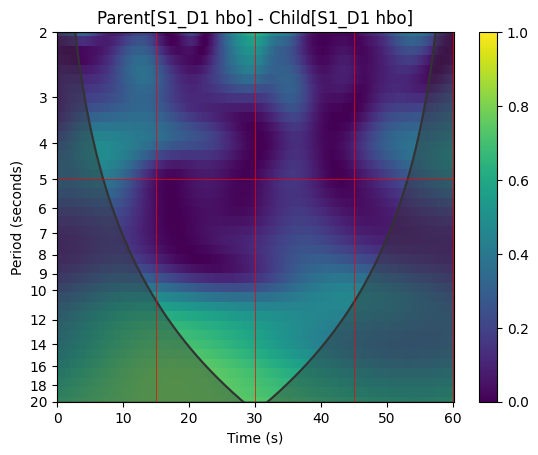

In [7]:
_ = dyad.wtcs[0].plot()


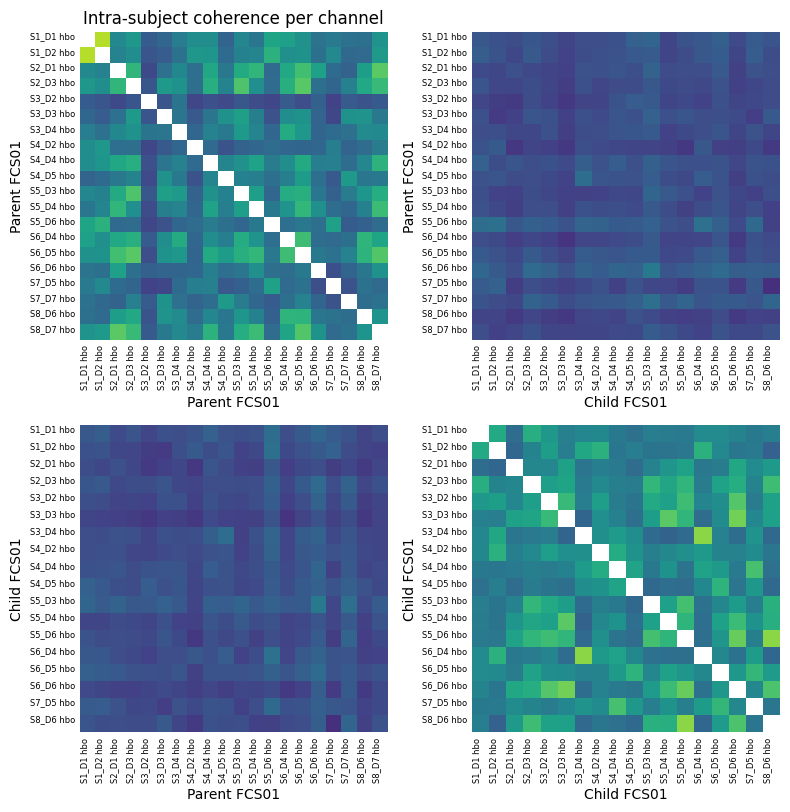

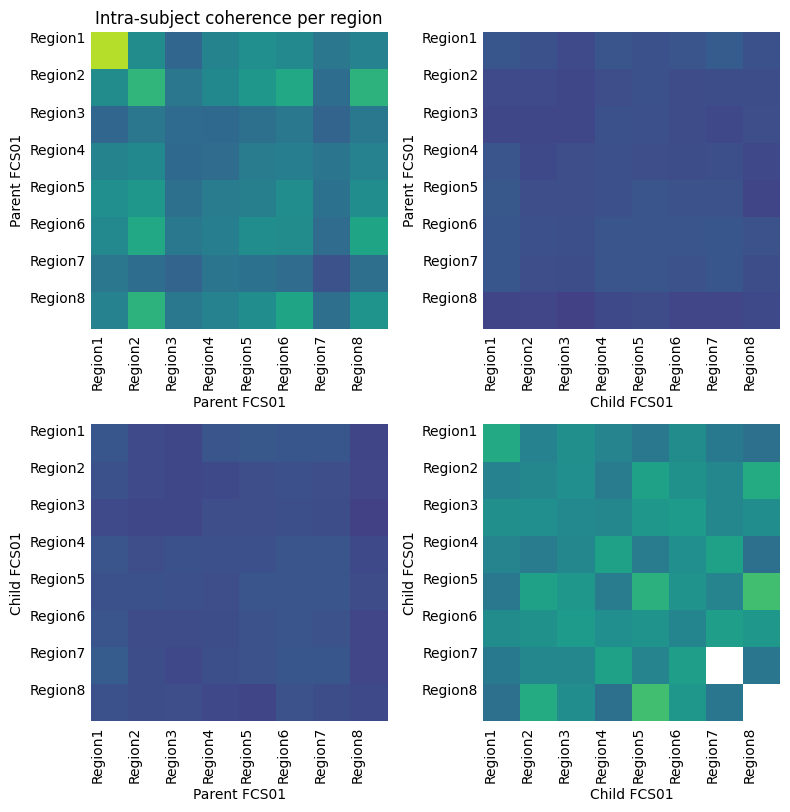

In [24]:
_ = dyad.plot_coherence_matrix_per_channel().axes[0].set_title('Intra-subject coherence per channel')
_ = dyad.plot_coherence_matrix_per_roi().axes[0].set_title('Intra-subject coherence per region')


## Cohort


## Cohort Coherence processing

We now apply the same strategy on a cohort of dyads. We define a baseline task and a sample task.

The resulting is a `Cohort` object, which encapsulates all the logic of processing, computing WTC and preparing pandas dataframe for analysis.

In [9]:
# Instanciate subjects and dyads objects

preprocessor = fnirs.MnePreprocessorRawToHaemo()
tasks = [
    Task('baseline', onset_time=0, duration=60),
    Task('task_foo', onset_time=60, duration=60),
]

n_dyads = 4
all_dyads = []

# truncate for this example
dyad_paths_keys = list(dyad_paths.keys())[:n_dyads]

for dyad_key in dyad_paths_keys:
    parent = fnirs.Subject(label=f'Parent {dyad_key}', tasks=tasks, channel_roi=channel_roi)
    parent.load_file(dyad_paths[dyad_key]['parent'], preprocessor)

    child = fnirs.Subject(label=f'Child {dyad_key}', tasks=tasks, channel_roi=channel_roi)
    child.load_file(dyad_paths[dyad_key]['child'], preprocessor)

    dyad = fnirs.Dyad(parent, child, label=dyad_key)

    all_dyads.append(dyad)

cohort = fnirs.Cohort(all_dyads)



### Wavelet object

Let's define our wavelet object. The following code simple instanciates the default wavelet. We do it explicitely for the sake of demonstration only.

The Wavelet uses caching to avoid recomputing continuous wavelet transforms all the time for the same channels.

Since the cache dictionary is shared by all dyads, a new pair with pre-computed CWT for channels will be much faster.

The cache is simply a python dictionary.


In [10]:
cache = dict()
wavelet = ComplexMorletWavelet(cache=cache)


Time for computing one dyad: 8 seconds
Expected time for 4 dyads: 31 seconds


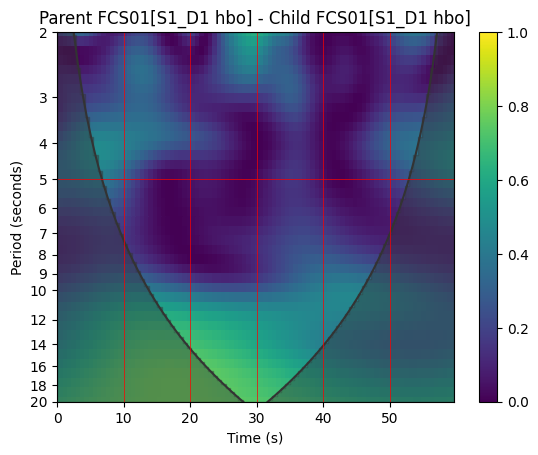

In [11]:
cohort.compute_wtcs(
    ch_match='hbo',
    wavelet=wavelet,
    with_intra=True, # compute intra subject for nicer display in quadrants
    bin_seconds=10,  # split in 10 seconds bins weight balancing. See `fnirs_wavelet_exploration.ipynb` for more details
    period_cuts=[5], # split frequencies in lower/higher to visualize which range has a higher coherence
    downsample=100,  # downsamples the wtc results for saving memory and allows faster display in plots
    verbose=False,   # use this flag to see the progress of processing
    # If memory usage gets too big during the processing, consider dropping the WTCs and store only the mean coherence
    #keep_wtcs=False, # delete computed WTCs after run, to avoid storing huge files
)

_ = cohort.dyads[0].wtcs[0].plot()


### Coherence matrix

Visualize the coherence matrix. Top left and bottom right are intra-subject coherence. Bottom left and top right are mirrors of the inter-subject coherence.


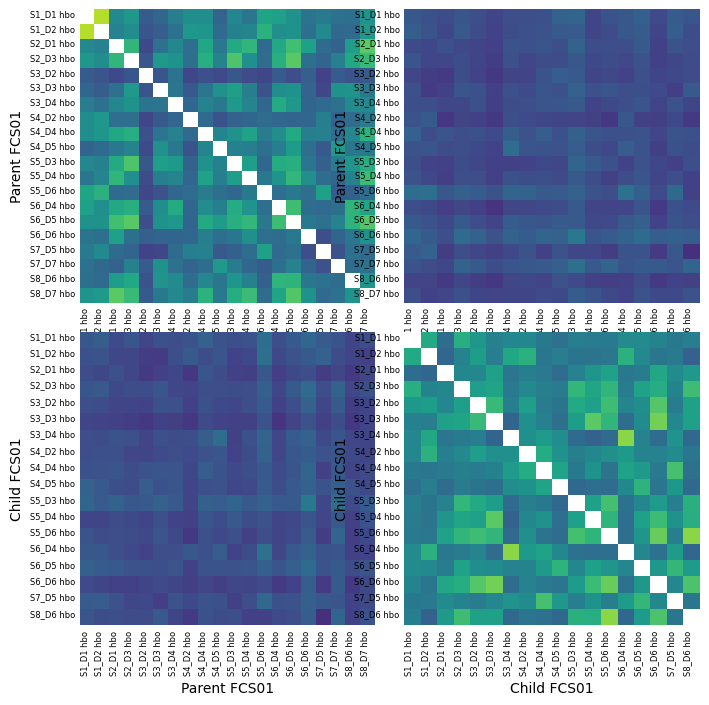

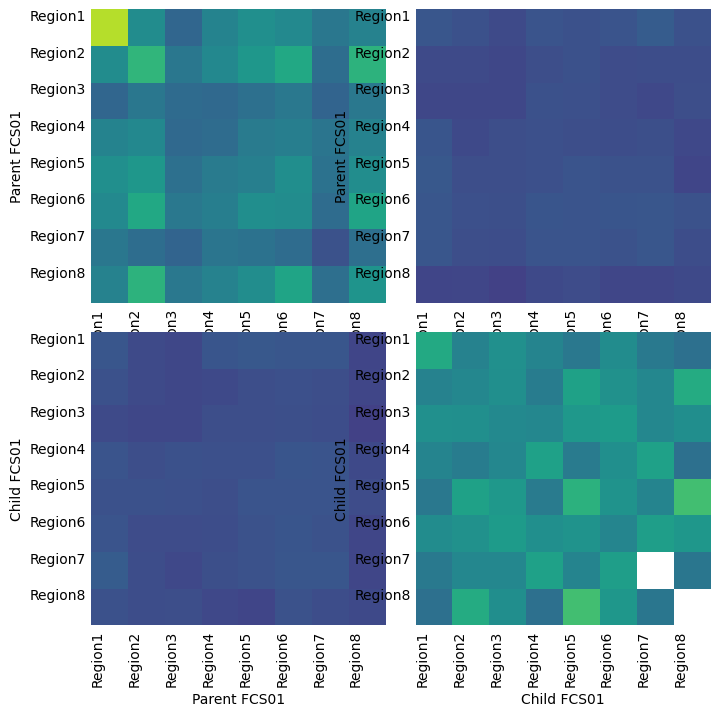

In [12]:
dyad = cohort.dyads[0]
_ = dyad.plot_coherence_matrix_per_channel()
_ = dyad.plot_coherence_matrix_per_roi()


The cohort object now has a pandas dataframe object that can be used or stored for further analysis


In [13]:
df = cohort.dyads[0].df
df


,dyad,is_intra,is_shuffle,subject1,subject2,roi1,roi2,channel1,channel2,task,epoch,section,bin,coherence,coherence_masked,bin_time_range,bin_period_range,wavelet_library,wavelet_name
0,FCS01,False,False,Parent FCS01,Child FCS01,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,0,0.238250,0.479167,0-10,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
1,FCS01,False,False,Parent FCS01,Child FCS01,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,1,NaN,0.969444,0-10,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
2,FCS01,False,False,Parent FCS01,Child FCS01,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,2,0.251053,0.000000,10-19,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
3,FCS01,False,False,Parent FCS01,Child FCS01,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,3,NaN,0.502778,10-19,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
4,FCS01,False,False,Parent FCS01,Child FCS01,Region1,Region1,S1_D1 hbo,S1_D1 hbo,baseline,0,0,4,0.152445,0.000000,19-29,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26011,Child FCS01(intra),True,False,Child FCS01,Child FCS01,Region8,Region8,S8_D6 hbo,S8_D6 hbo,task_foo,0,0,7,1.000000,0.075000,29-38,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
26012,Child FCS01(intra),True,False,Child FCS01,Child FCS01,Region8,Region8,S8_D6 hbo,S8_D6 hbo,task_foo,0,0,8,1.000000,0.000000,38-48,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
26013,Child FCS01(intra),True,False,Child FCS01,Child FCS01,Region8,Region8,S8_D6 hbo,S8_D6 hbo,task_foo,0,0,9,1.000000,0.386111,38-48,5.1-20.0,pywavelets,"cmor2,1[win:0.6]"
26014,Child FCS01(intra),True,False,Child FCS01,Child FCS01,Region8,Region8,S8_D6 hbo,S8_D6 hbo,task_foo,0,0,10,1.000000,0.212500,48-58,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"


### Save to disk

Multiple formats can be used to save the results to disk. 

| Format | Use case |
| - | - |
| `.csv` | Typical CSV file with a header, for sharing and importing in another python script or an external analysis software |
| `.feather` | Typical pandas dataframe storage format, for further analysis |
| `.pickle` | Used to reload the `Cohort` object for visualisation in a dashboard. |



In [14]:
csv_file_path = '../data/results/fnirs_cohort_example.csv'
cohort.save_csv(csv_file_path)


In [15]:
feather_file_path = '../data/results/fnirs_cohort_example.feather'
cohort.save_feather(feather_file_path)


In [16]:
# Save to disk

results_file_path = '../data/results/fnirs_cohort_example.pickle'
cohort.save_pickle(results_file_path)
